# Naive Bayes Classification

Before we worry about complex optimization algorithms or GPUs, we can already deploy our first classifier, relying only on simple statistical estimators and our understanding of conditional independence. Learning is all about making assumptions. If we want to classify a new data point that we've never seen before we have to make some assumptions about which data points are *similar* to each other.

One popular (and remarkably simple) algorithm is the Naive Bayes Classifier. Note that one natural way to express the classification task is via the probabilistic question: *what is the most likely label given the features?*. Formally, we wish to output the prediction $\hat{y}$ given by the expression:

$$\hat{y} = \text{argmax}_y \> p(y | \mathbf{x})$$

Unfortunately, this requires that we estimate $p(y | \mathbf{x})$ for every value of $\mathbf{x} = x_1, ..., x_d$. Imagine that each feature could take one of $2$ values. For example, the feature $x_1 = 1$ might signify that the word apple appears in a given document and $x_1 = 0$ would signify that it does not. If we had $30$ such binary features, that would mean that we need to be prepared to classify any of $2^{30}$ (over 1 billion!) possible values of the input vector $\mathbf{x}$.

Moreover, where is the learning? If we need to see every single possible example in order to predict the corresponding label then we're not really learning a pattern but just memorizing the dataset. Fortunately, by making some assumptions about conditional independence, we can introduce some inductive bias and build a model capable of generalizing from a comparatively modest selection of training examples.

To begin, let's use Bayes Theorem, to express the classifier as

$$\hat{y} = \text{argmax}_y \> \frac{p( \mathbf{x} | y) p(y)}{p(\mathbf{x})}$$

Note that the denominator is the normalizing term $p(\mathbf{x})$ which does not depend on the value of the label $y$. As a result, we only need to worry about comparing the numerator across different values of $y$. Even if calculating the demoninator turned out to be intractable, we could get away with ignoring it, so long as we could evaluate the numerator. Fortunately, however, even if we wanted to recover the normalizing constant, we could, since we know that $\sum_y p(y | \mathbf{x}) = 1$, hence we can always recover the normalization term.
Now, using the chain rule of probability, we can express the term $p( \mathbf{x} | y)$ as

$$p(x_1 |y) \cdot p(x_2 | x_1, y) \cdot ... \cdot p( x_d | x_1, ..., x_{d-1} y)$$

By itself, this expression doesn't get us any further. We still must estimate roughly $2^d$ parameters. However, if we assume that ***the features are conditionally independent of each other, given the label***, then suddenly we're in much better shape, as this term simplifies to $\prod_i p(x_i | y)$, giving us the predictor

$$ \hat{y} = \text{argmax}_y \> = \prod_i p(x_i | y) p(y)$$

Estimating each term in $\prod_i p(x_i | y)$ amounts to estimating just one parameter. So our assumption of conditional independence has taken the complexity of our model (in terms of the number of parameters) from an exponential dependence on the number of features to a linear dependence. Moreover, we can now make predictions for examples that we've never seen before, because we just need to estimate the terms $p(x_i | y)$, which can be estimated based on a number of different documents.

Let's take a closer look at the key assumption that the attributes are all independent of each other, given the labels, i.e., $p(\mathbf{x} | y) = \prod_i p(x_i | y)$. Consider classifying emails into spam and ham. It's fair to say that the occurrence of the words `Nigeria`, `prince`, `money`, `rich` are all likely indicators that the e-mail might be spam, whereas `theorem`, `network`, `Bayes` or `statistics` are good indicators that the exchange is less likely to be part of an orchestrated attempt to wheedle out your bank account numbers. Thus, we could model the probability of occurrence for each of these words, given the respective class and then use it to score the likelihood of a text. In fact, for a long time this *is* preciely how many so-called [Bayesian spam filters](https://en.wikipedia.org/wiki/Naive_Bayes_spam_filtering) worked.

## Optical Character Recognition

Since images are much easier to deal with, we will illustrate the workings of a Naive Bayes classifier for distinguishing digits on the MNIST dataset. The problem is that we don't actually know $p(y)$ and $p(x_i | y)$. So we need to *estimate* it given some training data first. This is what is called *training* the model. Estimating $p(y)$ is not too hard. Since we are only dealing with 10 classes, this is pretty easy - simply count the number of occurrences $n_y$ for each of the digits and divide it by the total amount of data $n$. For instance, if digit 8 occurs $n_8 = 5,800$ times and we have a total of $n = 60,000$ images, the probability estimate is $p(y=8) = 0.0967$.

Now on to slightly more difficult things—$p(x_i | y)$. Since we picked black and white images, $p(x_i | y)$ denotes the probability that pixel $i$ is switched on for class $y$. Just like before we can go and count the number of times $n_{iy}$ such that an event occurs and divide it by the total number of occurrences of y, i.e. $n_y$. But there's something slightly troubling: certain pixels may never be black (e.g. for very well cropped images the corner pixels might always be white). A convenient way for statisticians to deal with this problem is to add pseudo counts to all occurrences. Hence, rather than $n_{iy}$ we use $n_{iy}+1$ and instead of $n_y$ we use $n_{y} + 1$. This is also called [Laplace Smoothing](https://en.wikipedia.org/wiki/Additive_smoothing).

In [5]:
%matplotlib inline
import tqdm
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import torch
from torch import tensor
from torchvision import transforms, datasets

data_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor(), transforms.Normalize(mean=[0],std=[1])])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=data_transform)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=data_transform)

# Initialize the counters
xcount = torch.ones((784,10), dtype=torch.float32)
ycount = torch.ones((10), dtype=torch.float32)

for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

# using broadcast again for division
py = ycount / ycount.sum()
px = (xcount / ycount.reshape(1,10))

In [6]:
for data, label in mnist_train:
    y = int(label)
    ycount[y] += 1
    xcount[:,y] += data.reshape((784))

Now that we computed per-pixel counts of occurrence for all pixels, it's time to see how our model behaves. Time to plot it. This is where it is so much more convenient to work with images. Visualizing 28x28x10 probabilities (for each pixel for each class) would typically be an exercise in futility. However, by plotting them as images we get a quick overview. The astute reader probably noticed by now that these are some mean looking digits ...

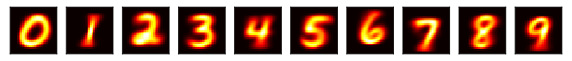

Class probabilities tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])


In [7]:
import matplotlib.pyplot as plt
fig, figarr = plt.subplots(1, 10, figsize=(10, 10))
for i in range(10):
    figarr[i].imshow(xcount[:, i].reshape((28, 28)).numpy(), cmap='hot')
    figarr[i].axes.get_xaxis().set_visible(False)
    figarr[i].axes.get_yaxis().set_visible(False)

plt.show()
print('Class probabilities', py)

Now we can compute the likelihoods of an image, given the model. This is statistician speak for $p(x | y)$, i.e. how likely it is to see a particular image under certain conditions (such as the label). Our Naive Bayes model which assumed that all pixels are independent tells us that

$$p(\mathbf{x} | y) = \prod_{i} p(x_i | y)$$

Using Bayes' rule, we can thus compute $p(y | \mathbf{x})$ via

$$p(y | \mathbf{x}) = \frac{p(\mathbf{x} | y) p(y)}{\sum_{y'} p(\mathbf{x} | y')}$$

Let's try this ...

In [8]:
# Get the first test item
data, label = mnist_test[0]
data = data.reshape((784,1))

# Compute the per pixel conditional probabilities
xprob = (px * data + (1-px) * (1-data))
# Take the product
xprob = xprob.prod(0) * py
print('Unnormalized Probabilities', xprob)
# Normalize
xprob = xprob / xprob.sum()
print('Normalized Probabilities', xprob)

Unnormalized Probabilities tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Normalized Probabilities tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


This went horribly wrong! To find out why, let's look at the per pixel probabilities. They're typically numbers between $0.001$ and $1$. We are multiplying $784$ of them. At this point it is worth mentioning that we are calculating these numbers on a computer, hence with a fixed range for the exponent. What happens is that we experience *numerical underflow*, i.e. multiplying all the small numbers leads to something even smaller until it is rounded down to zero. At that point we get division by zero with `nan` as a result.

To fix this we use the fact that $\log a b = \log a + \log b$, i.e. we switch to summing logarithms. This will get us unnormalized probabilities in log-space. To normalize terms we use the fact that

$$\frac{\exp(a)}{\exp(a) + \exp(b)} = \frac{\exp(a + c)}{\exp(a + c) + \exp(b + c)}$$

In particular, we can pick $c = -\max(a,b)$, which ensures that at least one of the terms in the denominator is $1$.

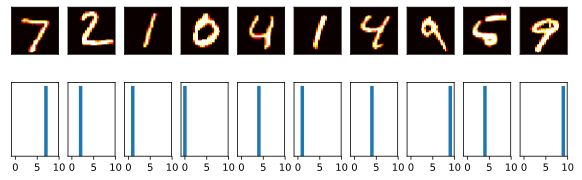

In [12]:
logpx = torch.log(px)
logpxneg = torch.log(1-px)
logpy = torch.log(py)

def bayespost(data):
    # We need to incorporate the prior probability p(y) since p(y|x) is
    # proportional to p(x|y) p(y)
    logpost = logpy.clone()
    logpost += (logpx * data + logpxneg * (1-data)).sum(0)
    # Normalize to prevent overflow or underflow by subtracting the largest
    # value
    logpost -= torch.max(logpost)
    # Compute the softmax using logpx
    post = torch.exp(logpost).numpy()
    post /= np.sum(post)
    return post

fig, figarr = plt.subplots(2, 10, figsize=(10, 3))

# Show 10 images
ctr = 0
for data, label in mnist_test:
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)

    # Bar chart and image of digit
    figarr[1, ctr].bar(range(10), post)
    figarr[1, ctr].axes.get_yaxis().set_visible(False)
    figarr[0, ctr].imshow(x.reshape((28, 28)).numpy(), cmap='hot')
    figarr[0, ctr].axes.get_xaxis().set_visible(False)
    figarr[0, ctr].axes.get_yaxis().set_visible(False)
    ctr += 1

    if ctr == 10:
        break

plt.show()

As we can see, this classifier works pretty well in many cases. However, the second last digit shows that it can be both incompetent and overly confident of its incorrect estimates. That is, even if it is horribly wrong, it generates probabilities close to 1 or 0. Not a classifier we should use very much nowadays any longer. To see how well it performs overall, let's compute the overall accuracy of the classifier.

In [13]:
# Initialize counter
ctr = 0
err = 0

for data, label in mnist_test:
    ctr += 1
    x = data.reshape((784,1))
    y = int(label)

    post = bayespost(x)
    if (post[y] < post.max()):
        err += 1

print('Naive Bayes has an error rate of', err/ctr)

Naive Bayes has an error rate of 0.1553


Modern deep networks achieve error rates of less than 0.01. While Naive Bayes classifiers used to be popular in the 80s and 90s, e.g. for spam filtering, their heydays are over. The poor performance is due to the incorrect statistical assumptions that we made in our model: we assumed that each and every pixel are *independently* generated, depending only on the label. This is clearly not how humans write digits, and this wrong assumption led to the downfall of our overly naive (Bayes) classifier. Time to start building Deep Networks.

## Summary

* Naive Bayes is an easy to use classifier that uses the assumption
  $p(\mathbf{x} | y) = \prod_i p(x_i | y)$.
* The classifier is easy to train but its estimates can be very wrong.
* To address overly confident and nonsensical estimates, the
  probabilities $p(x_i|y)$ are smoothed, e.g. by Laplace
  smoothing. That is, we add a constant to all counts.
* Naive Bayes classifiers don't exploit any correlations between
  observations.

## Exercises

1. Design a Naive Bayes regression estimator where $p(x_i | y)$ is a normal distribution.
1. Under which situations does Naive Bayes work?
1. An eyewitness is sure that he could recognize the perpetrator with 90% accuracy, if he were to encounter him again.
   * Is this a useful statement if there are only 5 suspects?
   * Is it still useful if there are 50?